# Text Classficiation with DistilBERT (IMDB Dataset)

***

## Contents
1. [Overview](#overview)
2. [Data Preprocessing](#preprocess)
3. [Data Exploration](#exploration)
4. [Modelling](#bert)
5. [Conclusion](#conclusion)

***

<a id = 'overview'></a>
### 1. *Overview*
In this notebook we will be exploring the [IMDB dataset](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) available on Kaggle, containing 50,000 reviews categorised as either positive or negative reviews. A text classification model will then be fine-tuned over DistilBERT and evaluated.

***

In [1]:
import pandas as pd
import numpy as np
import random
from collections import Counter
from datasets import load_dataset, Dataset

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve

from transformers import AutoTokenizer, DistilBertTokenizerFast
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import torch
import evaluate
from bs4 import BeautifulSoup
import lxml

C:\Users\wenhao\anaconda3\envs\ML\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


***
<a id = 'preprocess'></a>
### 2. *Data Preprocessing*

We will begin by initialising certain variables that will be used over the course of this notebook, before importing the dataset using pandas.

In [2]:
data_path = 'IMDB Dataset.csv' 
text_column_name = "review" 
label_column_name = "sentiment" 

model_name = "distilbert-base-uncased" 
test_size = 0.2 
num_labels = 2 


In [3]:
df = pd.read_csv(data_path)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [5]:
df.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [6]:
df['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

We see that this is a balanced dataset with a 1:1 ratio of positive and negative reviews, hence there is no need to handle class imbalances.

Looking at the review we see that html tags exists in the dataset, we will remove them as part of data cleaning making use of BeautifulSoup package to parse our reviews. Additionally, we will also encode our "sentiment" column.

In [7]:
class Cleaner():
  def __init__(self):
    pass
  def put_line_breaks(self,text):
    text = text.replace('</p>','</p>\n')
    return text
  def remove_html_tags(self,text):
    cleantext = BeautifulSoup(text, "lxml").text
    return cleantext
  def clean(self,text):
    text = self.put_line_breaks(text)
    text = self.remove_html_tags(text)
    return text

In [8]:
cleaner = Cleaner()
df['text_cleaned'] = df[text_column_name].apply(cleaner.clean)
df.head()

C:\Users\wenhao\AppData\Local\Temp\ipykernel_34920\4246655815.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  cleantext = BeautifulSoup(text, "lxml").text


,review,sentiment,text_cleaned
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming tec...
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is..."


In [9]:
le = preprocessing.LabelEncoder()
le.fit(df[label_column_name].tolist())
df['label'] = le.transform(df[label_column_name].tolist())
df.head()

,review,sentiment,text_cleaned,label
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [10]:
df['wordcount'] = df['text_cleaned'].str.split().str.len()
df.head()

,review,sentiment,text_cleaned,label,wordcount
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...,1,301
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming tec...,1,156
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...,1,162
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...,0,132
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is...",1,222


In [11]:
df.wordcount.describe()

count    50000.000000
mean       227.114620
std        168.278914
min          4.000000
25%        124.000000
50%        170.000000
75%        275.000000
max       2450.000000
Name: wordcount, dtype: float64

To help with the upcoming data exploration we have engineered a new feature to show the wordcount of each review entry, and a quick look shows most of the reviews have less than 275 words.

<a id='exploration'></a>
### 3. Data Exploration
Next, we will take a closer look at the distributions of wordcounts to investigate it they show any differences between positive and negative reviews.

C:\Users\wenhao\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\wenhao\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


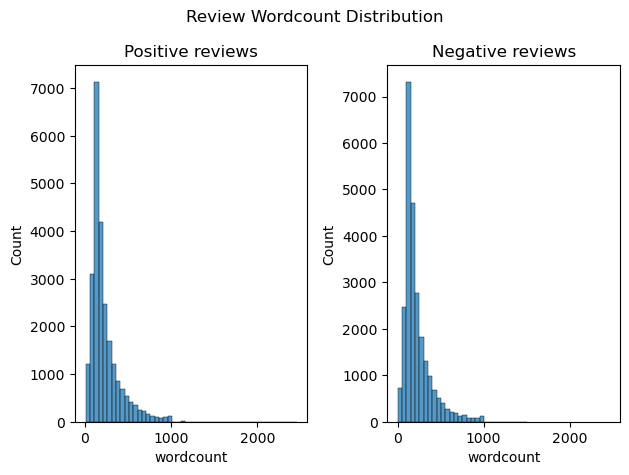

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
sns.histplot(data=df.loc[df['sentiment']=='positive'], x='wordcount', ax=ax1, binwidth=50)
sns.histplot(data=df.loc[df['sentiment']=='negative'], x='wordcount', ax=ax2, binwidth=50)
fig.suptitle('Review Wordcount Distribution')
ax1.set_title('Positive reviews')
ax2.set_title('Negative reviews')
fig.tight_layout()

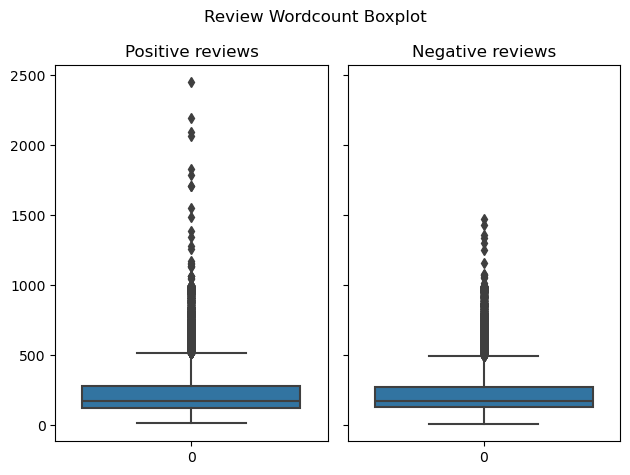

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
sns.boxplot(data=df.loc[df['sentiment']=='positive']['wordcount'].values, ax=ax1)
sns.boxplot(data=df.loc[df['sentiment']=='negative']['wordcount'].values, ax=ax2)
fig.suptitle('Review Wordcount Boxplot')
ax1.set_title('Positive reviews')
ax2.set_title('Negative reviews')
fig.tight_layout()

Looking at the above histograms and boxplots of wordcounts for Positive and Negative reviews, we see that the distributions are almost the same, except for a few outliers under our positive reviews.

Next we will look at some of the most common words and phrases within the dataset.

In [14]:
def most_common_words(df, n):
    corpus = []
    stop = set(stopwords.words('english'))
    for review in df.text_cleaned:
        for word in review.split():
            if word.strip().lower() not in stop and word.strip().lower().isalpha():
                corpus.append(word.strip())
    
    counter_words = Counter(corpus).most_common(n)
    counter_words = dict(counter_words)
    tmp = pd.DataFrame(columns = ["Word", 'Count'])
    tmp["Word"] = list(counter_words.keys())
    tmp['Count'] = list(counter_words.values())
    return tmp

# def most_common_ngrams(corpus, n, gram):
#     vec = CountVectorizer(ngram_range = (gram, gram)).fit(corpus)
#     bow = vec.transform(corpus)
#     word_sum = bow.sum(axis=0)
#     word_freq = [(word, word_sum[0, idx]) for word, idx in vec.vocabulary_.items()]
#     word_freq = sorted(word_freq, key = lambda x: x[1], reverse = True)
#     return word_freq[:n]

def most_common_ngrams(df, n, gram, name):
    corpus = []
    stop = set(stopwords.words('english'))
    for review in df.text_cleaned:
        words = review.split()
        words = [word for word in words if word not in stop]
        for i in range(len(words)-gram+1):
            corpus.append(' '.join(words[i:i+gram]))
    counter_ngrams = Counter(corpus).most_common(n)
    ngrams = dict(counter_ngrams)
    tmp = pd.DataFrame(columns = [str(name), 'Count'])
    tmp[str(name)] = list(ngrams.keys())
    tmp['Count'] = list(ngrams.values())
    return tmp

In [15]:
positive_corpus = most_common_words(df.loc[df['sentiment']=='positive'], 10)
negative_corpus = most_common_words(df.loc[df['sentiment']=='negative'], 10)

positive_bigram = most_common_ngrams(df.loc[df['sentiment']=='positive'], 10, 2, 'Bigram')
negative_bigram = most_common_ngrams(df.loc[df['sentiment']=='negative'], 10, 2, 'Bigram')
positive_trigram = most_common_ngrams(df.loc[df['sentiment']=='positive'], 10, 3, 'Trigram')
negative_trigram = most_common_ngrams(df.loc[df['sentiment']=='negative'], 10, 3, 'Trigram')

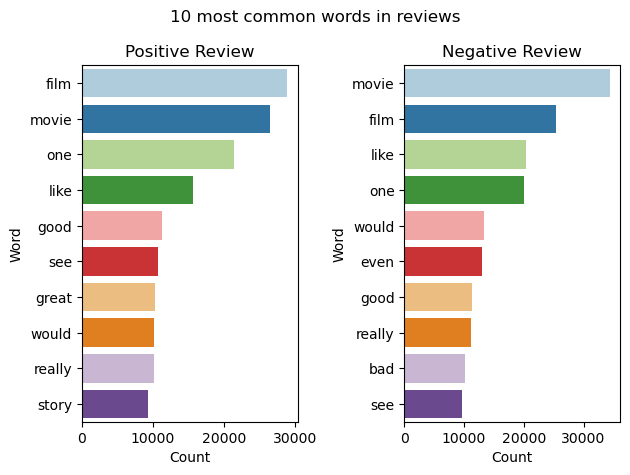

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2)
sns.barplot(data=positive_corpus, x='Count', y='Word', ax=ax1, palette = 'Paired')
sns.barplot(data=negative_corpus, x='Count', y='Word', ax=ax2, palette = 'Paired')
fig.suptitle('10 most common words in reviews')
ax1.set_title('Positive Review')
ax2.set_title('Negative Review')
plt.tight_layout()

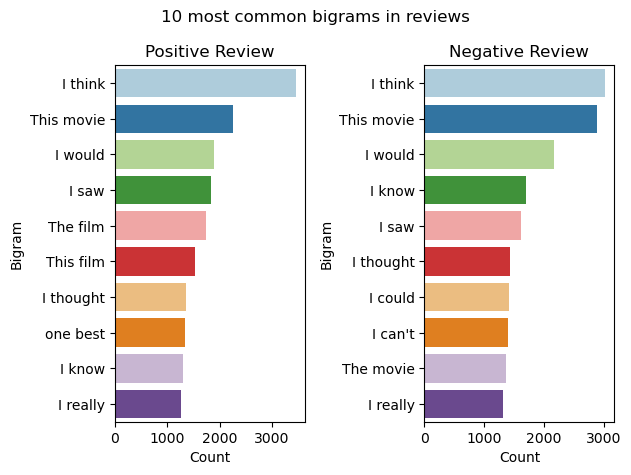

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2)
sns.barplot(data=positive_bigram, x='Count', y='Bigram', ax=ax1, palette = 'Paired')
sns.barplot(data=negative_bigram, x='Count', y='Bigram', ax=ax2, palette = 'Paired')
fig.suptitle('10 most common bigrams in reviews')
ax1.set_title('Positive Review')
ax2.set_title('Negative Review')
plt.tight_layout()

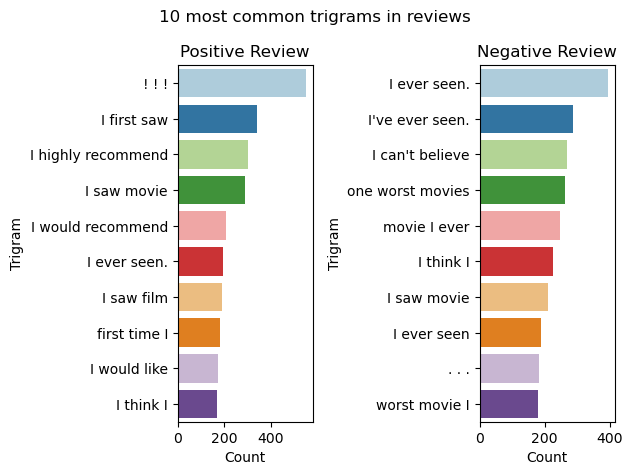

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2)
sns.barplot(data=positive_trigram, x='Count', y='Trigram', ax=ax1, palette = 'Paired')
sns.barplot(data=negative_trigram, x='Count', y='Trigram', ax=ax2, palette = 'Paired')
fig.suptitle('10 most common trigrams in reviews')
ax1.set_title('Positive Review')
ax2.set_title('Negative Review')
plt.tight_layout()

We are able to see phrases such as "I highly recommend" and "I would recommend" appearing in positive reviews giving a positive connotation while phrases like "one worst movies" and "worst movie I" appear in negative reviews giving a negative connotation. However, many of the most common words and phrases appear in both positive and negative reviews, suggesting that it would be better to focus on the exact phrases used rather than how frequently they are used.

For the purpose of data exploration, the above plots were created after removing stopwords from our dataset, in the next section where we fine tune a BERT model for text classification stopwords will be left in the dataset to provide context clues for our model.

***

<a id = 'bert'></a>
### 4. Modelling (BERT)
In this section we will fine tune a BERT model for text classification, due to limited computation power, we will be sampling 10% of the original dataset to use for training and validation, and another 5% as our holdout set for model evaluation after training is completed.

In [19]:
# Reduce dataset to 5000 rows maintaining 1:1 ratio of review sentiments, shuffle and reset index
data = df.groupby('sentiment').apply(lambda x: x.sample(frac=0.15)).droplevel('sentiment')
holdout = pd.concat([data.iloc[:1250],data.iloc[6250:]]).sample(frac=1)
holdout = holdout.rename(columns={'label': 'true_label'})
holdout

,review,sentiment,text_cleaned,true_label,wordcount
16369,"Oh, this is such a glorious musical. There's a...",positive,"Oh, this is such a glorious musical. There's a...",1,121
11852,As an old white housewife I can still apprecia...,positive,As an old white housewife I can still apprecia...,1,114
49783,Saw this movie at the Rotterdam IFF. You may q...,positive,Saw this movie at the Rotterdam IFF. You may q...,1,54
21792,The minutiae of what's involved in carrying ou...,positive,The minutiae of what's involved in carrying ou...,1,152
21757,Greetings again from the darkness. What a reli...,positive,Greetings again from the darkness. What a reli...,1,271
...,...,...,...,...,...
17962,I'm glad I rented this movie for one reason: i...,negative,I'm glad I rented this movie for one reason: i...,0,148
34361,"Overall, a well done movie. There were the par...",positive,"Overall, a well done movie. There were the par...",1,349
3722,Doesn't anyone bother to check where this kind...,negative,Doesn't anyone bother to check where this kind...,0,200
38341,Such a long awaited movie.. But it has disappo...,negative,Such a long awaited movie.. But it has disappo...,0,206


In [20]:
data = data.iloc[1250:6250].sample(frac=1)
data

,review,sentiment,text_cleaned,label,wordcount
29963,This is Peter Falk's film. Period.<br /><br />...,negative,This is Peter Falk's film. Period.I was 10 yea...,0,246
35201,I don't see that much wrong with this movie. G...,positive,I don't see that much wrong with this movie. G...,1,218
25325,This movie wasn't that bad when compared to th...,negative,This movie wasn't that bad when compared to th...,0,151
44489,There is no greater disservice to do to histor...,positive,There is no greater disservice to do to histor...,1,538
7754,Posh Spice Victoria Beckham and her alleged ne...,negative,Posh Spice Victoria Beckham and her alleged ne...,0,657
...,...,...,...,...,...
44529,"OK from the point of view of an American, who ...",negative,"OK from the point of view of an American, who ...",0,189
11739,"I love bad movies: Showgirls, Plan 9 from Oute...",negative,"I love bad movies: Showgirls, Plan 9 from Oute...",0,122
3805,It was probably just my DVD---but I would not ...,negative,It was probably just my DVD---but I would not ...,0,185
5756,"For some unknown reason, 7 years ago, I watche...",negative,"For some unknown reason, 7 years ago, I watche...",0,127


In [21]:
# train / validation dataset splits
df_train, df_test = train_test_split(data[['text_cleaned','label']], test_size=test_size)

In [22]:
# converting out pandas dataframes to pytorch datasets
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

In [23]:
# tokenizer to convert our words to tokens
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

def preprocess_function(examples):
    return tokenizer(examples["text_cleaned"], truncation=True)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [26]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [29]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy = "epoch",
    logging_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
    
)

In [30]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.359300,0.253881,0.901000
2,0.176800,0.296619,0.906000
3,0.095000,0.434078,0.895000
4,0.041500,0.437259,0.906000
5,0.019900,0.460906,0.904000


TrainOutput(global_step=1250, training_loss=0.13849494819641114, metrics={'train_runtime': 520.6204, 'train_samples_per_second': 38.416, 'train_steps_per_second': 2.401, 'total_flos': 2603187224294592.0, 'train_loss': 0.13849494819641114, 'epoch': 5.0})

It appears that validation loss has increased after the first epoch while training loss continued to decrease, suggesting some overfitting happening in this case. However, looking at validation accuracy we see that the performance of the remained constant through all 5 epochs.

We will see if this performance holds true for our holdout set, extracting the model's predictions (label and score) from our pipeline.

In [31]:
from transformers import pipeline
classifier = pipeline(
    task='text-classification',
    model=model,
    tokenizer=tokenizer,
    device=0,
    truncation=True,
    batch_size=8
)

In [32]:
holdout['result'] = holdout['text_cleaned'].apply(lambda x: classifier(x))
holdout['sentiment'] = holdout['result'].str[0].str['label']
holdout['score'] = holdout['result'].str[0].str['score']
holdout

C:\Users\wenhao\anaconda3\envs\ML\Lib\site-packages\transformers\pipelines\base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


,review,sentiment,text_cleaned,true_label,wordcount,result,score
16369,"Oh, this is such a glorious musical. There's a...",LABEL_1,"Oh, this is such a glorious musical. There's a...",1,121,"[{'label': 'LABEL_1', 'score': 0.9983893632888...",0.998389
11852,As an old white housewife I can still apprecia...,LABEL_1,As an old white housewife I can still apprecia...,1,114,"[{'label': 'LABEL_1', 'score': 0.9985773563385...",0.998577
49783,Saw this movie at the Rotterdam IFF. You may q...,LABEL_0,Saw this movie at the Rotterdam IFF. You may q...,1,54,"[{'label': 'LABEL_0', 'score': 0.7969191670417...",0.796919
21792,The minutiae of what's involved in carrying ou...,LABEL_1,The minutiae of what's involved in carrying ou...,1,152,"[{'label': 'LABEL_1', 'score': 0.9989652633666...",0.998965
21757,Greetings again from the darkness. What a reli...,LABEL_1,Greetings again from the darkness. What a reli...,1,271,"[{'label': 'LABEL_1', 'score': 0.9985762834548...",0.998576
...,...,...,...,...,...,...,...
17962,I'm glad I rented this movie for one reason: i...,LABEL_0,I'm glad I rented this movie for one reason: i...,0,148,"[{'label': 'LABEL_0', 'score': 0.9990332126617...",0.999033
34361,"Overall, a well done movie. There were the par...",LABEL_0,"Overall, a well done movie. There were the par...",1,349,"[{'label': 'LABEL_0', 'score': 0.9182419180870...",0.918242
3722,Doesn't anyone bother to check where this kind...,LABEL_0,Doesn't anyone bother to check where this kind...,0,200,"[{'label': 'LABEL_0', 'score': 0.9989865422248...",0.998987
38341,Such a long awaited movie.. But it has disappo...,LABEL_0,Such a long awaited movie.. But it has disappo...,0,206,"[{'label': 'LABEL_0', 'score': 0.9987562894821...",0.998756


In [33]:
holdout['sentiment']= holdout['sentiment'].map({'LABEL_1':1, 'LABEL_0':0})

In [34]:
holdout

,review,sentiment,text_cleaned,true_label,wordcount,result,score
16369,"Oh, this is such a glorious musical. There's a...",1,"Oh, this is such a glorious musical. There's a...",1,121,"[{'label': 'LABEL_1', 'score': 0.9983893632888...",0.998389
11852,As an old white housewife I can still apprecia...,1,As an old white housewife I can still apprecia...,1,114,"[{'label': 'LABEL_1', 'score': 0.9985773563385...",0.998577
49783,Saw this movie at the Rotterdam IFF. You may q...,0,Saw this movie at the Rotterdam IFF. You may q...,1,54,"[{'label': 'LABEL_0', 'score': 0.7969191670417...",0.796919
21792,The minutiae of what's involved in carrying ou...,1,The minutiae of what's involved in carrying ou...,1,152,"[{'label': 'LABEL_1', 'score': 0.9989652633666...",0.998965
21757,Greetings again from the darkness. What a reli...,1,Greetings again from the darkness. What a reli...,1,271,"[{'label': 'LABEL_1', 'score': 0.9985762834548...",0.998576
...,...,...,...,...,...,...,...
17962,I'm glad I rented this movie for one reason: i...,0,I'm glad I rented this movie for one reason: i...,0,148,"[{'label': 'LABEL_0', 'score': 0.9990332126617...",0.999033
34361,"Overall, a well done movie. There were the par...",0,"Overall, a well done movie. There were the par...",1,349,"[{'label': 'LABEL_0', 'score': 0.9182419180870...",0.918242
3722,Doesn't anyone bother to check where this kind...,0,Doesn't anyone bother to check where this kind...,0,200,"[{'label': 'LABEL_0', 'score': 0.9989865422248...",0.998987
38341,Such a long awaited movie.. But it has disappo...,0,Such a long awaited movie.. But it has disappo...,0,206,"[{'label': 'LABEL_0', 'score': 0.9987562894821...",0.998756


In [35]:
print('Accuracy: ', accuracy_score(holdout['true_label'], holdout['sentiment']))
print('F1: ', f1_score(holdout['true_label'], holdout['sentiment']))
print('Confusion Matrix: ', confusion_matrix(holdout['true_label'], holdout['sentiment']))

Accuracy:  0.9044
F1:  0.9051210797935689
Confusion Matrix:  [[1121  129]
 [ 110 1140]]


Predicting on our holdout set, we see that the model achieves approximately 90.44% accuracy and an F1 score of 0.9051. This is consistent with our validation accuracy while training, suggesting that the model will perform well on similar reviews that are unseen.

***

<a id='conclusion'></a>
### 5. Conclusion
In this notebook we have explored the IMDB Movie Reviews dataset using some techniques commonly found in NLP and sentiment analysis. We have also fine tuned a text classificaiton model on DistilBert, achieving a good performance of ~90% accuracy on unseen dataset.